In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

from pathlib import Path

from data_preprocess import get_disparate_key_frames, get_key_frames_by_cluster

2023-03-06 16:25:10.827332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 16:25:10.973835: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-06 16:25:11.352146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/:/home/victor/miniconda3/envs/tf/lib/
2023-03-06 16:25:11.352207: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [2]:
data_dir = Path('data')
train_path = 'data/train.csv'

In [3]:
df_train = pd.read_csv(train_path)
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [4]:
signs = list(df_train.sign.unique())
signs.sort()
# signs

# Animation

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

dir = 'data'
train = pd.read_csv(f'{dir}/train.csv')

In [6]:
def get_hand_points(hand):
    x = [[hand[0][0], hand[1][0], hand[2][0], hand[3][0], hand[4][0]], # Thumb
         [hand[5][0], hand[6][0], hand[7][0], hand[8][0]], # Index
         [hand[9][0], hand[10][0], hand[11][0], hand[12][0]], 
         [hand[13][0], hand[14][0], hand[15][0], hand[16][0]], 
         [hand[17][0], hand[18][0], hand[19][0], hand[20][0]], 
         [hand[0][0], hand[5][0], hand[9][0], hand[13][0], hand[17][0], hand[0][0]]]

    y = [[hand[0][1], hand[1][1], hand[2][1], hand[3][1], hand[4][1]],  #Thumb
         [hand[5][1], hand[6][1], hand[7][1], hand[8][1]], # Index
         [hand[9][1], hand[10][1], hand[11][1], hand[12][1]], 
         [hand[13][1], hand[14][1], hand[15][1], hand[16][1]], 
         [hand[17][1], hand[18][1], hand[19][1], hand[20][1]], 
         [hand[0][1], hand[5][1], hand[9][1], hand[13][1], hand[17][1], hand[0][1]]] 
    return x, y

def get_pose_points(pose):
    x = [[pose[8][0], pose[6][0], pose[5][0], pose[4][0], pose[0][0], pose[1][0], pose[2][0], pose[3][0], pose[7][0]], 
         [pose[10][0], pose[9][0]], 
         [pose[22][0], pose[16][0], pose[20][0], pose[18][0], pose[16][0], pose[14][0], pose[12][0], 
          pose[11][0], pose[13][0], pose[15][0], pose[17][0], pose[19][0], pose[15][0], pose[21][0]], 
         [pose[12][0], pose[24][0], pose[26][0], pose[28][0], pose[30][0], pose[32][0], pose[28][0]], 
         [pose[11][0], pose[23][0], pose[25][0], pose[27][0], pose[29][0], pose[31][0], pose[27][0]], 
         [pose[24][0], pose[23][0]]
        ]

    y = [[pose[8][1], pose[6][1], pose[5][1], pose[4][1], pose[0][1], pose[1][1], pose[2][1], pose[3][1], pose[7][1]], 
         [pose[10][1], pose[9][1]], 
         [pose[22][1], pose[16][1], pose[20][1], pose[18][1], pose[16][1], pose[14][1], pose[12][1], 
          pose[11][1], pose[13][1], pose[15][1], pose[17][1], pose[19][1], pose[15][1], pose[21][1]], 
         [pose[12][1], pose[24][1], pose[26][1], pose[28][1], pose[30][1], pose[32][1], pose[28][1]], 
         [pose[11][1], pose[23][1], pose[25][1], pose[27][1], pose[29][1], pose[31][1], pose[27][1]], 
         [pose[24][1], pose[23][1]]
        ]
    return x, y

In [7]:
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / 543)
    data = data.values.reshape(n_frames, 543, len(data_columns))
    return data.astype(np.float32)

In [8]:
def animation_frame(f: int):
    frame = data[f]
    face = frame[0:468]
    left = frame[468:489]
    pose = frame[489:522]
    right = frame[522:543]
    lx, ly = get_hand_points(left)
    rx, ry = get_hand_points(right)
    px, py = get_pose_points(pose)
    ax.clear()
    ax.plot(face[:,0], face[:,1], '.')
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    for i in range(len(rx)):
        ax.plot(rx[i], ry[i])
    for i in range(len(px)):
        ax.plot(px[i], py[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
        

In [9]:
sign_name = np.random.choice(df_train.sign.unique())
sign_name='balloon'

train_landmark_files/27610/1319253290.parquet
data.shape=(10, 543, 3)
The sign being shown here is: balloon


train_landmark_files/37779/1226477062.parquet
data.shape=(18, 543, 3)
The sign being shown here is: balloon


train_landmark_files/25571/3453579351.parquet
data.shape=(62, 543, 3)
The sign being shown here is: balloon


train_landmark_files/27610/3591118006.parquet
data.shape=(15, 543, 3)
The sign being shown here is: balloon


train_landmark_files/16069/816770471.parquet
data.shape=(116, 543, 3)
The sign being shown here is: balloon


Done


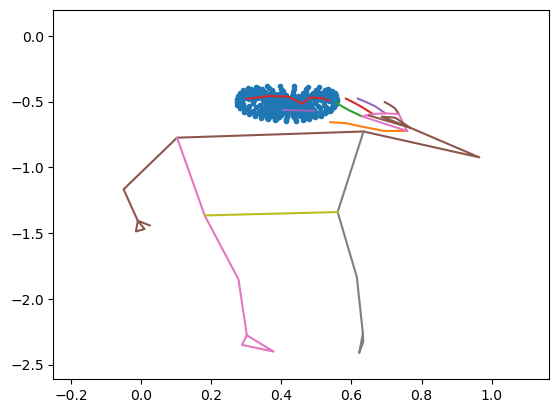

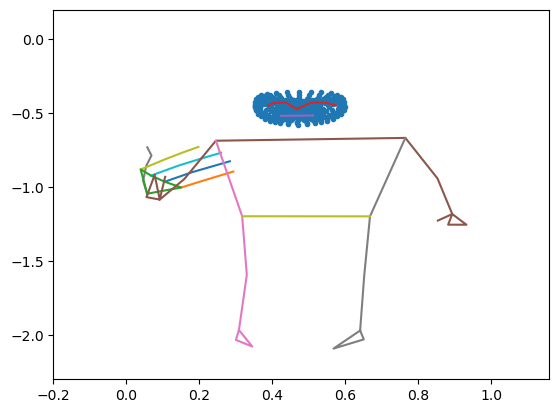

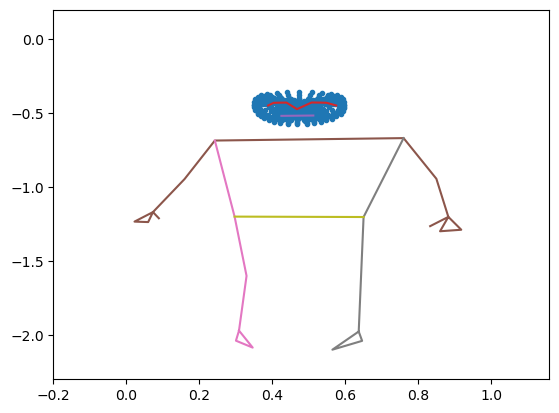

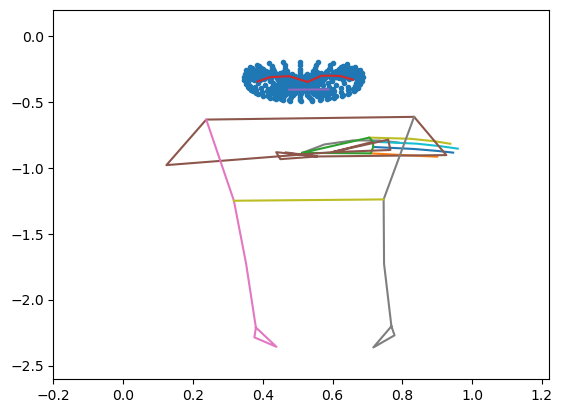

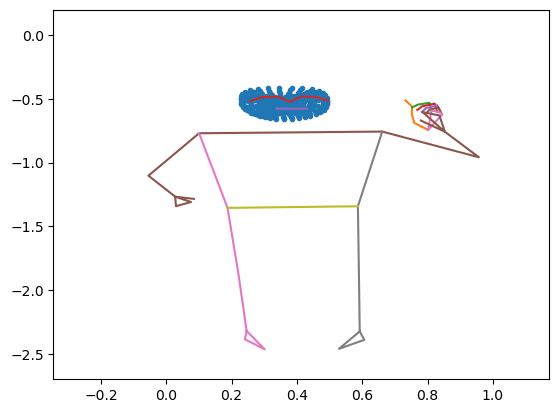

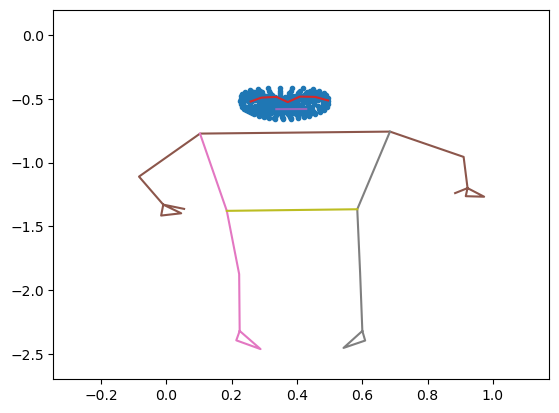

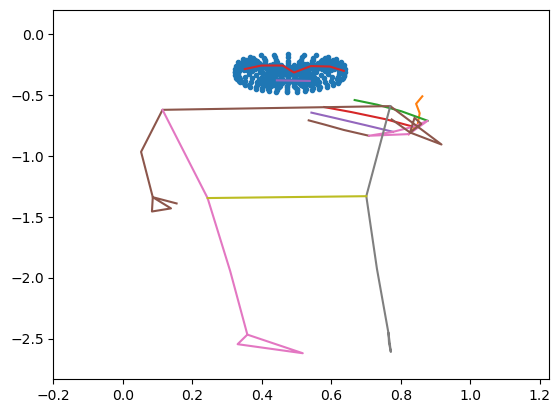

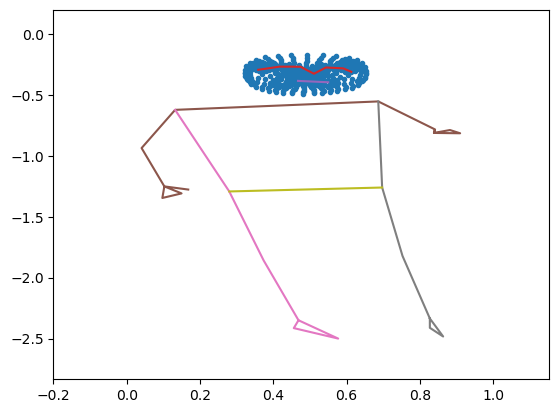

In [18]:
subset = df_train[df_train.sign == sign_name]

animations = []
for path_to_sign in subset.sample(5, random_state=27)['path'].values:
# for path_to_sign in subset.iloc[:5]['path'].values:
    try:
        print(path_to_sign)
        data = load_relevant_data_subset(f'{dir}/{path_to_sign}')
        data[:,:,1] *= -1 # flip over
        print(f'{data.shape=}')
        print(f"The sign being shown here is: {train[train.path==f'{path_to_sign}'].sign.values[0]}")
        data_old = data
        data = get_disparate_key_frames(data, n_frames=5)

        ## These values set the limits on the graph to stabilize the video
        xmin = np.nanmin(data[:,:,0]) - 0.2
        xmax = np.nanmax(data[:,:,0]) + 0.2
        ymin = np.nanmin(data[:,:,1]) - 0.2
        ymax = np.nanmax(data[:,:,1]) + 0.2

        fig, ax = plt.subplots()
        l, = ax.plot([], [])
        animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data.shape[0])))
        display(HTML(animation.to_html5_video()))

        data = get_key_frames_by_cluster(data, n_frames=5)

        ## These values set the limits on the graph to stabilize the video
        xmin = np.nanmin(data[:,:,0]) - 0.2
        xmax = np.nanmax(data[:,:,0]) + 0.2
        ymin = np.nanmin(data[:,:,1]) - 0.2
        ymax = np.nanmax(data[:,:,1]) + 0.2

        fig, ax = plt.subplots()
        l, = ax.plot([], [])
        animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data.shape[0])))
        display(HTML(animation.to_html5_video()))
    except:
        pass
print('Done')

train_landmark_files/18796/1355085954.parquet
data.shape=(8, 543, 3)
The sign being shown here is: cute


Done


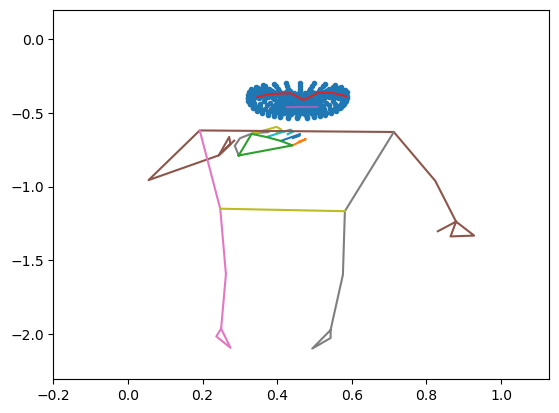

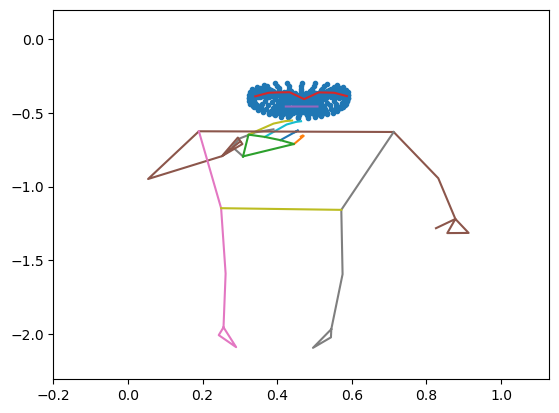

In [11]:
subset = df_train[df_train.sign == np.random.choice(df_train.sign.unique())]

animations = []
for path_to_sign in ['train_landmark_files/18796/1355085954.parquet']:#subset.sample(5, random_state=27)['path'].values:
# for path_to_sign in subset.iloc[:5]['path'].values:
    print(path_to_sign)
    data = load_relevant_data_subset(f'{dir}/{path_to_sign}')
    data[:,:,1] *= -1 # flip over
    print(f'{data.shape=}')
    print(f"The sign being shown here is: {train[train.path==f'{path_to_sign}'].sign.values[0]}")
    data_old = data
    data_new = get_disparate_key_frames(data, n_frames=10, padding=False)
    data = data_old
#     break
    ## These values set the limits on the graph to stabilize the video
    xmin = np.nanmin(data[:,:,0]) - 0.2
    xmax = np.nanmax(data[:,:,0]) + 0.2
    ymin = np.nanmin(data[:,:,1]) - 0.2
    ymax = np.nanmax(data[:,:,1]) + 0.2

    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data.shape[0])))
    display(HTML(animation.to_html5_video()))
    
    data = data_new
    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data_new.shape[0])))
    display(HTML(animation.to_html5_video()))

print('Done')

train_landmark_files/18796/1355085954.parquet
data.shape=(8, 543, 3)
The sign being shown here is: cute


Done


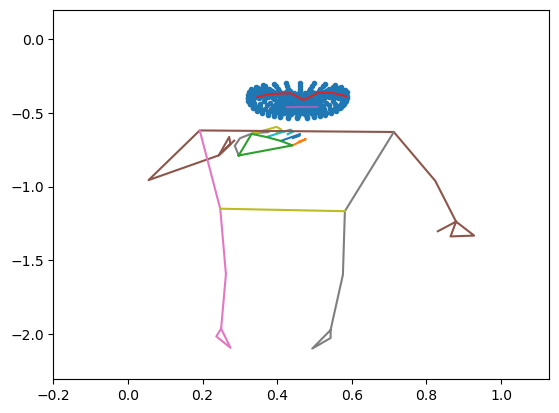

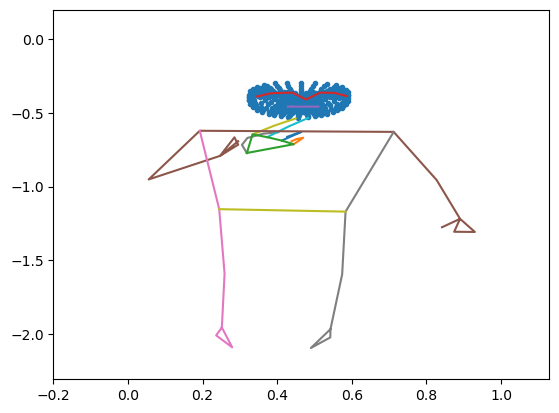

In [12]:
subset = df_train[df_train.sign == np.random.choice(df_train.sign.unique())]

animations = []
for path_to_sign in ['train_landmark_files/18796/1355085954.parquet']:#subset.sample(5, random_state=27)['path'].values:
# for path_to_sign in subset.iloc[:5]['path'].values:
    print(path_to_sign)
    data = load_relevant_data_subset(f'{dir}/{path_to_sign}')
    data[:,:,1] *= -1 # flip over
    print(f'{data.shape=}')
    print(f"The sign being shown here is: {train[train.path==f'{path_to_sign}'].sign.values[0]}")
    data_old = data
    data_new = get_key_frames_by_cluster(data, n_frames=3)
    data = data_old
#     break
    ## These values set the limits on the graph to stabilize the video
    xmin = np.nanmin(data[:,:,0]) - 0.2
    xmax = np.nanmax(data[:,:,0]) + 0.2
    ymin = np.nanmin(data[:,:,1]) - 0.2
    ymax = np.nanmax(data[:,:,1]) + 0.2

    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data.shape[0])))
    display(HTML(animation.to_html5_video()))
    
    data = data_new
    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data_new.shape[0])))
    display(HTML(animation.to_html5_video()))

print('Done')

In [13]:
frame0 = 0
n_frames = 10
frames = [frame0] # Always include first frame (as defined by input params)
curr_frame_idx = frames[0]
frame_diffs = {}
data=data_old
find_dist = lambda f0,f1: np.linalg.norm(data[f1] - data[f0])

# TODO: Skip for a high percent of NaNs (set to all zeros)
where_are_NaNs = np.isnan(data)
data[where_are_NaNs] = 0



while len(frames) < n_frames:
    # Get most different curr_frame
    most_different_frame_rel_idx = np.argmax([
        find_dist(curr_frame_idx, fi) # Find all distances from curr_frame
        for fi in range(curr_frame_idx, data.shape[0])
        if not np.all(data[fi] == 0) # Skip if all points are 0s (Had NaNs)
    ])
    most_different_frame_idx = (
        most_different_frame_rel_idx # relative position from frame
        + curr_frame_idx # Offset by the current frame index
    )
    frames.append(most_different_frame_idx)
    curr_frame_idx = most_different_frame_idx
    # Possible not enough different frames
    if curr_frame_idx >= data.shape[0] - 1:
        print(
            f'not enough frames: '
            f'Want {n_frames} frames; Have {len(frames)} '
        )
        # All leftover frames are just the default all zeros
        # TODO: Copy rest of frames to end?

not enough frames: Want 10 frames; Have 2 
not enough frames: Want 10 frames; Have 3 
not enough frames: Want 10 frames; Have 4 
not enough frames: Want 10 frames; Have 5 
not enough frames: Want 10 frames; Have 6 
not enough frames: Want 10 frames; Have 7 
not enough frames: Want 10 frames; Have 8 
not enough frames: Want 10 frames; Have 9 
not enough frames: Want 10 frames; Have 10 


In [14]:
data_old

array([[[ 0.4578792 , -0.45668137, -0.03921206],
        [ 0.4629844 , -0.42183125, -0.06117174],
        [ 0.46162263, -0.43222693, -0.03417462],
        ...,
        [ 0.4708571 , -0.6561899 , -0.01634276],
        [ 0.4682886 , -0.65292037,  0.01010338],
        [ 0.4631396 , -0.660403  ,  0.02893307]],

       [[ 0.4579574 , -0.45578015, -0.03838968],
        [ 0.4637226 , -0.42257002, -0.06226604],
        [ 0.4624564 , -0.43279994, -0.03446472],
        ...,
        [ 0.48307633, -0.66801816, -0.0230396 ],
        [ 0.47773948, -0.66623807,  0.0012346 ],
        [ 0.46909508, -0.67147607,  0.01842107]],

       [[ 0.45611742, -0.4563647 , -0.03717556],
        [ 0.46413264, -0.4225737 , -0.06173133],
        [ 0.46282753, -0.43251696, -0.03390228],
        ...,
        [ 0.47434235, -0.66964555, -0.03942471],
        [ 0.46173736, -0.6750961 , -0.01738487],
        [ 0.45128524, -0.6859085 , -0.00073476]],

       ...,

       [[ 0.45704922, -0.45700672, -0.03773205],
        [ 0

In [15]:
data_old.shape

(8, 543, 3)

In [16]:
data_old.shape#(8, 543*3)

(8, 543, 3)

In [17]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto"
               ).fit(data_old.reshape(8, 543*3))
print(kmeans.labels_)

centers = kmeans.cluster_centers_

(data_old.reshape(8,543*3) == ).sum()

SyntaxError: invalid syntax (4037007211.py, line 9)

In [ ]:
data_old.shape

In [ ]:
np.prod(data_old.shape[1:])

In [ ]:
frames.sort()

In [ ]:
frames = []
for c in centers:
    i = np.argmax([np.linalg.norm(n-c) for n in data_old.reshape(8,543*3)])
    frames.append(i)
frames
data_old[frames]

In [ ]:
## These values set the limits on the graph to stabilize the video
data = data_old[frames]
xmin = np.nanmin(data[:,:,0]) - 0.2
xmax = np.nanmax(data[:,:,0]) + 0.2
ymin = np.nanmin(data[:,:,1]) - 0.2
ymax = np.nanmax(data[:,:,1]) + 0.2

fig, ax = plt.subplots()
l, = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=list(range(data.shape[0])))
display(HTML(animation.to_html5_video()))


In [ ]:
data = load_relevant_data_subset(f'{dir}/train_landmark_files/18796/1355085954.parquet')
print(data.shape)
first_and_disparate_key_frames(data, n_frames=10)[:8] == data

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import json
import gc
from sklearn.model_selection import train_test_split
# import missingno as msno
import multiprocessing as mp

from pathlib import Path
import datetime

In [ ]:
face_x = np.zeros((3,468,2))
left_x = np.zeros((3,21,2))
xs = []
xs.append(np.mean(face_x, axis=0))
xs.append(np.mean(left_x,0))

In [ ]:
# xfeat = 482 * 2 + 21 * 2
# xfeat = 

In [ ]:
xs[0].shape